## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from sklearn.neighbors import KDTree

from tqdm.notebook import tqdm

from sklearn.model_selection import RepeatedKFold as RKF

from sklearn.feature_extraction.text import TfidfVectorizer as tfidfvec
from sklearn.feature_extraction.text import CountVectorizer as cntvec

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

/home/danroor/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.neighb = n_neighbors
        self.alg = algorithm
        self.metric = metric
    
    def fit(self, X, Y):
        self.Ytrain = np.array(Y)
        if self.alg == 'brute':
            self.Xtrain = X
        elif self.alg == 'kd_tree':
            self.Xtrain = KDTree(X)
    
    def predict(self, X):
        Ypred = np.array([]).astype(int)
        if self.alg == 'brute':
            neighb_indices = cdist(X, self.Xtrain).argsort(axis = 1)[:, :self.neighb]
            
        elif self.alg == 'kd_tree':
            _, neighb_indices = self.Xtrain.query(X, k = self.neighb)
        
        neighb_arr = self.Ytrain[neighb_indices]
        for neighb in neighb_arr:
            neighb, cnt = np.unique(neighb, axis = 0, return_counts = True)
            cnt = cnt.argsort()
            Ypred = np.append(Ypred, neighb[cnt[np.size(cnt) - 1]])
        
        return Ypred

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [10]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [11]:
%time clf.fit(X_train, y_train)

CPU times: user 3.15 ms, sys: 0 ns, total: 3.15 ms
Wall time: 2.33 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [12]:
%time my_clf.fit(X_train, y_train)

CPU times: user 32 µs, sys: 8 µs, total: 40 µs
Wall time: 45.8 µs


In [13]:
%time clf.predict(X_test)

CPU times: user 3.92 ms, sys: 4.16 ms, total: 8.07 ms
Wall time: 7.18 ms


array([1, 0, 0, 2, 1, 0, 0, 2, 2, 1, 0, 1, 1, 2, 2])

In [14]:
%time my_clf.predict(X_test)

CPU times: user 13 ms, sys: 81 µs, total: 13.1 ms
Wall time: 10.9 ms


array([1, 0, 0, 2, 1, 0, 0, 2, 2, 1, 0, 1, 1, 2, 2])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [24]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [26]:
%time clf.fit(X_train, y_train)

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 1.6 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [27]:
%time my_clf.fit(X_train, y_train)

CPU times: user 245 µs, sys: 62 µs, total: 307 µs
Wall time: 271 µs


In [28]:
%time clf.predict(X_test)

CPU times: user 5.22 ms, sys: 0 ns, total: 5.22 ms
Wall time: 4.1 ms


array([1, 2, 2, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0])

In [29]:
%time my_clf.predict(X_test)

CPU times: user 5.79 ms, sys: 2.51 ms, total: 8.29 ms
Wall time: 6.78 ms


array([1, 2, 2, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0])

In [30]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [3]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [4]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [5]:
vectorizer = cntvec(min_df = 10)
matrix = vectorizer.fit_transform(data)
matrix = np.array(matrix.todense())

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [6]:
folds = RKF(n_splits = 3, n_repeats = 10).split(matrix)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [7]:
def optimal_neighb(X, Y, folds, metr = 'euclidean'):
    scores = np.array(range(10), dtype=float)
    i = 0
    score = np.array([], dtype = float)
    my_clf = MyKNeighborsClassifier(n_neighbors = 2, algorithm = 'brute', metric = metr)
    for train, test in tqdm(folds):
        my_clf.fit(X[train], Y[train])
        correct = my_clf.predict(X[test]) == Y[test]
        score = np.append(score, np.average(correct))
        if i % 3 == 2:
            scores[i // 3] = np.mean(score)
            score = np.array([], dtype = float)
            my_clf = MyKNeighborsClassifier(n_neighbors = i // 3 + 3, algorithm = 'brute', metric = metr)
        i += 1
    return scores

In [8]:
scores = optimal_neighb(matrix, target, folds)

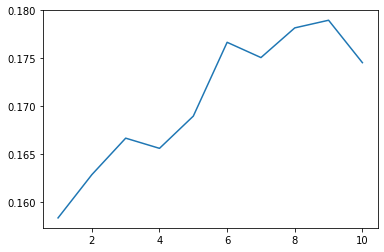

In [9]:
plt.plot(range(1, 11), scores)
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [10]:
vectorizer2 = tfidfvec(min_df = 10)
matrix2 = vectorizer2.fit_transform(data)
matrix2 = np.array(matrix2.todense())
folds = RKF(n_splits = 3, n_repeats = 10).split(matrix2)

scores2 = optimal_neighb(matrix2, target, folds, metr = 'cosine')

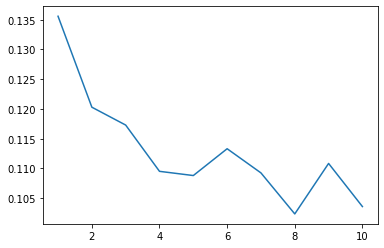

In [11]:
plt.plot(range(1, 11), scores2)
plt.show()

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [12]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
test_data = newsgroups['data']
test_target = newsgroups['target']

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.